### Continent specific PFT height allometries 

In [1]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
from scipy.io import netcdf as nc
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random

import math as m
from scipy.optimize import curve_fit
from scipy.stats import linregress

nan = float("nan")

import modp as mp

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import cartopy.crs as ccrs
from matplotlib import cm

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))

/global/homes/j/jneedham/.conda/envs/myenv/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:

df_trop_orig = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv')


In [3]:
df_trop = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical rain forest']

### Martinez-cano height allometry

In [4]:
def d2hmc (d, p1, p2, p3) :
    h = (p1 * d**p2) / (p3 + d**p2)
    return h

initial_guess = [58.0, 0.73, 21.8]


In [5]:
def fit_d2hmc (df, initial_guess) :
    # remove nas  in dbh and height
    df = df.dropna(subset=['height','dbh'])
    # remove outliers
    df  = df[df['height_outlier']=='N']
   
    height_ps, covariance = curve_fit(f=d2hmc, xdata=np.array(df['dbh']), ydata=np.array(df['height']),
                                           p0=initial_guess)

    return height_ps 

### Banin et al. equations

In [6]:
def  d2hbanin (d, a, b, c) : 
    h  = a - b * np.exp(-c * d)
    return h

In [7]:
def fit_d2hbanin2 (df, initial_guess) :
    # remove nas  in dbh and height
    df = df.dropna(subset=['height','dbh'])
    # remove outliers
    df  = df[df['height_outlier']=='N']
   
    height_ps, covariance = curve_fit(f=d2hbanin, xdata=np.array(df['dbh']), ydata=np.array(df['height']),
                                           p0=initial_guess)

    return height_ps 

In [8]:
def fit_d2hbanin1(dbhs,  params) : 
    height =  [d2hbanin(d, params[0], params[1], params[2])  for  d  in dbhs]
    return height

#### Terryn et al. pantropical model fit to  TLS data

In [9]:
def d2h_terryn(d) : 
    h = np.exp(0.91 + 0.86 * np.log(d) - 0.06 * np.log(d)**2)
    return h 

### Fit Martinez Cano equation to Tallo data

In [10]:
height_ps_mc = [fit_d2hmc(d[1], initial_guess) for d in df_trop.groupby('realm')]

In [11]:
df_trop.groupby('realm').size()

realm
Afrotropic      6475
Australasia    27578
Indo-Malaya    47532
Neotropic      22997
Oceania          501
Palearctic       808
dtype: int64

In [12]:
height_ps_mc

[array([61.01797595,  0.87719445, 38.08187347]),
 array([40.84752041,  1.08505165, 29.61410085]),
 array([2.63152891e+07, 6.73937468e-01, 1.47095179e+07]),
 array([69.6053814 ,  0.80161612, 34.7882537 ]),
 array([26.73888726,  0.95005428, 21.36017957]),
 array([6.57257885e+06, 5.31873189e-01, 2.29871447e+06])]

### Fit Banin equation to Tallo data

In [13]:
initial_guess = [45.08, 42.80, 0.025]
height_ps_b = [fit_d2hbanin2(d[1], initial_guess) for d in df_trop.groupby('realm')]

### Load Banin parameters and calculate those curves

In [14]:
param_ranges_full = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/banin_h_allom_params.csv')

In [15]:
param_ranges_full

,realm,a,b,c
0,Americas,35.83,31.15,0.029
1,Africa,45.08,42.80,0.025
2,Asia,58.25,53.58,0.019
3,Australia,34.97,31.08,0.030


In [16]:
ds = np.arange(1, 250, 1)
banin_americas = fit_d2hbanin1(ds, param_ranges_full[param_ranges_full['realm'] == 'Americas'].values.flatten().tolist()[1:4])
banin_africa = fit_d2hbanin1(ds,  param_ranges_full[param_ranges_full['realm'] == 'Africa'].values.flatten().tolist()[1:4])
banin_asia = fit_d2hbanin1(ds,  param_ranges_full[param_ranges_full['realm'] == 'Asia'].values.flatten().tolist()[1:4])
banin_australia = fit_d2hbanin1(ds, param_ranges_full[param_ranges_full['realm'] == 'Australia'].values.flatten().tolist()[1:4])

### Fit MM just to dipterocarps in Indo-Malaya

In [17]:
df_dipt = df_trop.loc[df_trop['realm'] == 'Indo-Malaya']
df_dipt
df_dipt = df_dipt.loc[df_dipt['family'] == 'Dipterocarpaceae']

In [18]:
initial_guess = [58.0, 0.73, 21.8]
dipt_ps = fit_d2hmc(df_dipt, initial_guess)
curve_dipt = [d2hmc(d, dipt_ps[0], dipt_ps[1], dipt_ps[2])  for  d  in ds]

In [19]:
initial_guess = [58.25, 53.58, 0.019]
dipt_ps = fit_d2hbanin2(df_dipt, initial_guess)
curve_dipt_exp = [d2hbanin(d, dipt_ps[0], dipt_ps[1], dipt_ps[2])  for  d  in ds]

In [20]:
dipt_ps

array([6.15197405e+01, 5.90712494e+01, 1.27051556e-02])

### Terryn et al. curve

In [21]:
curve_terryn = [d2h_terryn(d)  for  d  in ds]

### Plot them 

In [22]:
realms  = df_trop['realm'].unique()

In [23]:
print(realms)

['Indo-Malaya' 'Neotropic' 'Australasia' 'Afrotropic' 'Palearctic'
 'Oceania']


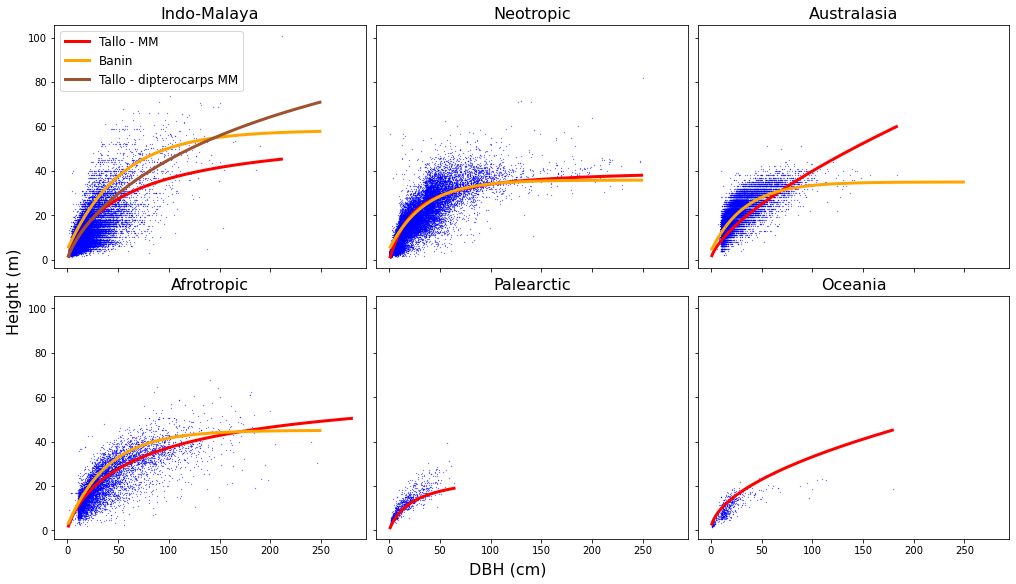

In [24]:
fig1, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(0,len(realms)): 
    realm = realms[i]
    ps_mc = height_ps_mc[i]
    ps_b = height_ps_b[i]
    df = df_trop.loc[df_trop['realm'] == realm]
    dbh = np.arange(1, df['dbh'].max(),1)
    curve_mc = [d2hmc(d, ps_mc[0], ps_mc[1], ps_mc[2])  for  d  in dbh]
    curve_b = [d2hbanin(d, ps_b[0], ps_b[1], ps_b[2])  for  d  in dbh]
    

    axs[i].scatter(df['dbh'], df['height'], s=0.05, color='blue')
    axs[i].plot(dbh, curve_mc, color='red',label='Tallo - MM',linewidth=3.0)
    #axs[i].plot(ds, curve_terryn, color='grey', label = 'Terryn', linewidth=3.0)
    #axs[i].plot(dbh, curve_b, color='grey',label='Tallo - exponential',linewidth=3.0)
    axs[i].set_title(realm,  fontsize=16)
 
fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)

### add in the banin models
axs[0].plot(ds, banin_asia, color='orange', label='Banin',linewidth=3.0)
axs[0].plot(ds, curve_dipt, color='sienna', label='Tallo - dipterocarps MM', linewidth=3.0)
#axs[0].plot(ds, curve_dipt_exp, color='navy', label='Tallo - dipterocarps exp', linewidth=3.0)
axs[1].plot(ds, banin_americas, color='orange',linewidth=3.0)
axs[2].plot(ds, banin_australia, color='orange',linewidth=3.0)
axs[3].plot(ds, banin_africa, color='orange',linewidth=3.0)

axs[0].legend(fontsize=12)

### Repeat but fit separately to savanna and forest trees

In [25]:
df_rf = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical rain forest']
df_df = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical dry forest']
df_s = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical savanna']

In [26]:
initial_guess = [58.0, 0.73, 21.8]

In [27]:
height_ps_mc_rf = [fit_d2hmc(d[1], initial_guess) for d in df_rf.groupby('realm', sort=False)]
height_ps_mc_df = [fit_d2hmc(d[1], initial_guess) for d in df_df.groupby('realm', sort=False)]
height_ps_mc_s = [fit_d2hmc(d[1], initial_guess) for d in df_s.groupby('realm', sort=False)]

In [28]:
realms_rf = df_rf['realm'].unique()
realms_df = df_df['realm'].unique()
realms_s = df_s['realm'].unique()

In [29]:
print(realms_rf)
height_ps_mc_rf

['Indo-Malaya' 'Neotropic' 'Australasia' 'Afrotropic' 'Palearctic'
 'Oceania']


[array([2.63152891e+07, 6.73937468e-01, 1.47095179e+07]),
 array([69.6053814 ,  0.80161612, 34.7882537 ]),
 array([40.84752041,  1.08505165, 29.61410085]),
 array([61.01797595,  0.87719445, 38.08187347]),
 array([6.57257885e+06, 5.31873189e-01, 2.29871447e+06]),
 array([26.73888726,  0.95005428, 21.36017957])]

In [30]:
print(realms_df)
height_ps_mc_df

['Indo-Malaya' 'Neotropic' 'Afrotropic']


[array([7.13449418e+07, 5.87419739e-01, 4.28663438e+07]),
 array([16.21393927,  0.84868343,  6.89905218]),
 array([12.17780551,  0.86512021,  5.73938989])]

In [31]:
print(realms_s)
height_ps_mc_s

['Australasia' 'Neotropic' 'Afrotropic' 'Indo-Malaya']


[array([43.3261613 ,  0.80358152, 27.19215902]),
 array([9.98032219e+07, 5.95266773e-01, 6.50672377e+07]),
 array([8.25761452e+07, 7.20354641e-01, 7.79363707e+07]),
 array([ 20.35200768,   1.52182214, 117.35091879])]

0
1
3


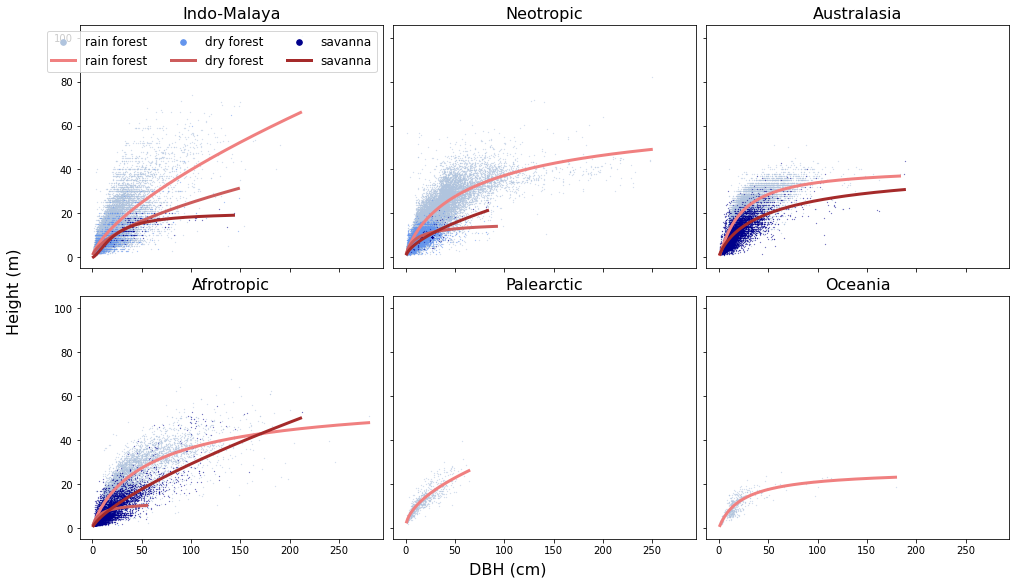

In [32]:
fig1, axs = plt.subplots(nrows=2, ncols=3, figsize=(14,8), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

for i in np.arange(0,len(realms_rf)): 
    realm = realms_rf[i]
    ps_rf = height_ps_mc_rf[i]
    tmp = df_rf.loc[df_rf['realm'] == realm]
    dbh_rf = np.arange(1, tmp['dbh'].max(),1)
    curve_rf = [d2hmc(d, ps_rf[0], ps_rf[1], ps_rf[2])  for  d  in dbh_rf]
    axs[i].scatter(tmp['dbh'], tmp['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
    axs[i].plot(dbh_rf, curve_rf, color='lightcoral',label='rain forest',linewidth=3.0)
    axs[i].set_title(realm,  fontsize=16)

for i in np.arange(0,len(realms_df)): 
    realm = realms_df[i]
    ps_df = height_ps_mc_df[i]
    tmp = df_df.loc[df_df['realm'] == realm]
    dbh_df = np.arange(1, tmp['dbh'].max(),1)
    curve_df = [d2hmc(d, ps_df[0], ps_df[1], ps_df[2])  for  d  in dbh_df]
    axsi = np.where(realms_rf == realm)[0][0]
    print(axsi)
    axs[axsi].scatter(tmp['dbh'], tmp['height'], s=0.05, color='cornflowerblue', label = 'dry forest')
    axs[axsi].plot(dbh_df, curve_df, color='indianred', label = 'dry forest', linewidth=3.0)

for i in np.arange(0,len(realms_s)): 
    realm = realms_s[i]
    ps_s = height_ps_mc_s[i]
    tmp = df_s.loc[df_s['realm'] == realm] 
    dbh_s = np.arange(1, tmp['dbh'].max(),1)
    curve_s = [d2hmc(d, ps_s[0], ps_s[1], ps_s[2])  for  d  in dbh_s]
    axsi =  np.where(realms_rf == realm)[0][0]
    axs[axsi].scatter(tmp['dbh'], tmp['height'], s=0.05, color='darkblue', label = 'savanna')
    axs[axsi].plot(dbh_s, curve_s, color='brown', label = 'savanna', linewidth=3.0)
    axs[axsi].set_title(realm,  fontsize=16)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)

axs[0].legend(fontsize=12, ncol=3, markerscale=25)

## Final parameters

- Indo-Malaya - Michaelis-Menten equation fit to dipterocarps for everggreen PFT and dry forests hydro-deciduous PFT
- Neo-tropics - Michaelis-Menten equation fit to all rain forest species for evergreen PFT, and dry forest for hydro-deciduous PFT
- Afrotropics - Michaelis-Menten equation fit to rain forest species for evergreen PFT and savanna for hydro-deciduous PFT

In [33]:
df_trop_orig = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv')

rf = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical rain forest']
df = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical dry forest']
s = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical savanna']

In [34]:
initial_guess = [58.0, 0.73, 21.8]

### Asia

#### Evergreen - Dipterocarpaceae

In [35]:
rf_asia = rf.loc[rf['realm'] == 'Indo-Malaya']
rf_asia = rf_asia.loc[rf_asia['family'] == 'Dipterocarpaceae']
rf_asia_ps = fit_d2hmc(rf_asia, initial_guess)
curve_rf_asia = [d2hmc(d, rf_asia_ps[0], rf_asia_ps[1], rf_asia_ps[2])  for  d  in ds]

In [36]:
print(rf_asia_ps)

[158.36468951   0.78216249  92.34041828]


#### Hydro-deciduous  - dry forests

In [37]:
df_asia = df.loc[df['realm'] == 'Indo-Malaya']
df_asia_ps = fit_d2hmc(df_asia, initial_guess)
curve_df_asia = [d2hmc(d, df_asia_ps[0], df_asia_ps[1], df_asia_ps[2])  for  d  in ds]

In [38]:
print(df_asia_ps)

[7.13449418e+07 5.87419739e-01 4.28663438e+07]


### Americas

#### Evergreen - rain forests

In [39]:
rf_americas = rf.loc[rf['realm'] == 'Neotropic']
rf_americas_ps = fit_d2hmc(rf_americas, initial_guess)
curve_rf_americas = [d2hmc(d, rf_americas_ps[0], rf_americas_ps[1], rf_americas_ps[2])  for  d  in ds]

In [40]:
print(rf_americas_ps)

[69.6053814   0.80161612 34.7882537 ]


#### Hydro-deciduous - dry forests

In [41]:
df_americas = df.loc[df['realm'] == 'Neotropic']
df_americas_ps = fit_d2hmc(df_americas, initial_guess)
curve_df_americas = [d2hmc(d, df_americas_ps[0], df_americas_ps[1], df_americas_ps[2])  for  d  in ds]

In [42]:
print(df_americas_ps)

[16.21393927  0.84868343  6.89905218]


### Africa

#### Evergreen - rain forest

In [43]:
rf_africa = rf.loc[rf['realm'] == 'Afrotropic']
rf_africa_ps = fit_d2hmc(rf_africa, initial_guess)
curve_rf_africa = [d2hmc(d, rf_africa_ps[0], rf_africa_ps[1], rf_africa_ps[2])  for  d  in ds]

In [44]:
print(rf_africa_ps)

[61.01797595  0.87719445 38.08187347]


#### Hydro-deciduos - savanna

In [45]:
s_africa = s.loc[s['realm'] == 'Afrotropic']
s_africa_ps = fit_d2hmc(s_africa, initial_guess)
curve_s_africa = [d2hmc(d, s_africa_ps[0], s_africa_ps[1], s_africa_ps[2])  for  d  in ds]

In [46]:
s_africa_ps

array([8.25761452e+07, 7.20354641e-01, 7.79363707e+07])

Text(0.02, 0.5, 'Height (m)')

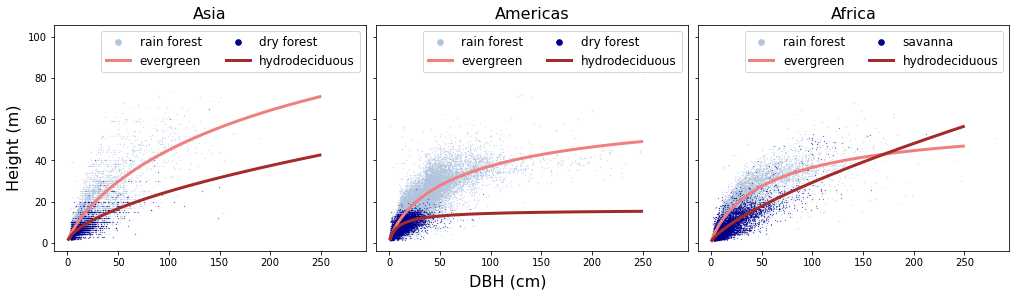

In [47]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(rf_asia['dbh'], rf_asia['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf_asia, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].scatter(df_asia['dbh'], df_asia['height'], s=0.05, color='darkblue', label = 'dry forest')
axs[0].plot(ds, curve_df_asia, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[0].set_title('Asia',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)

axs[1].scatter(rf_americas['dbh'], rf_americas['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[1].plot(ds, curve_rf_americas, color='lightcoral',label='evergreen',linewidth=3.0)
axs[1].scatter(df_americas['dbh'], df_americas['height'], s=0.05, color='darkblue', label = 'dry forest')
axs[1].plot(ds, curve_df_americas, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[1].set_title('Americas',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)

axs[2].scatter(rf_africa['dbh'], rf_africa['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[2].plot(ds, curve_rf_africa, color='lightcoral',label='evergreen',linewidth=3.0)
axs[2].scatter(s_africa['dbh'], s_africa['height'], s=0.05, color='darkblue', label = 'savanna')
axs[2].plot(ds, curve_s_africa, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[2].set_title('Africa',  fontsize=16)
axs[2].legend(fontsize=12, ncol=2, markerscale=25)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)



### Current  tropical height allometry

In [48]:
global_h = [d2hmc(d, 78.4087704, 0.8124383, 47.6666164)  for  d  in ds]

Text(0.02, 0.5, 'Height (m)')

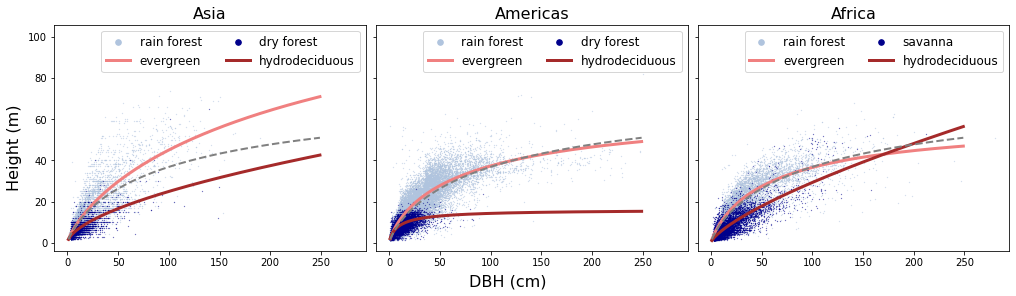

In [49]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(rf_asia['dbh'], rf_asia['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf_asia, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].scatter(df_asia['dbh'], df_asia['height'], s=0.05, color='darkblue', label = 'dry forest')
axs[0].plot(ds, curve_df_asia, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[0].set_title('Asia',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)
axs[0].plot(ds, global_h, color='grey', label='pantropical',linewidth=2.0,linestyle='--')

axs[1].scatter(rf_americas['dbh'], rf_americas['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[1].plot(ds, curve_rf_americas, color='lightcoral',label='evergreen',linewidth=3.0)
axs[1].scatter(df_americas['dbh'], df_americas['height'], s=0.05, color='darkblue', label = 'dry forest')
axs[1].plot(ds, curve_df_americas, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[1].set_title('Americas',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)
axs[1].plot(ds, global_h, color='grey', label='pantropical',linewidth=2.0,linestyle='--')


axs[2].scatter(rf_africa['dbh'], rf_africa['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[2].plot(ds, curve_rf_africa, color='lightcoral',label='evergreen',linewidth=3.0)
axs[2].scatter(s_africa['dbh'], s_africa['height'], s=0.05, color='darkblue', label = 'savanna')
axs[2].plot(ds, curve_s_africa, color='brown',label='hydrodeciduous',linewidth=3.0)
axs[2].set_title('Africa',  fontsize=16)
axs[2].legend(fontsize=12, ncol=2, markerscale=25)
axs[2].plot(ds, global_h, color='grey', label='pantropical',linewidth=2.0,linestyle='--')


fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)

### Modify the parameter file

In [50]:
# starting parameter file
input_fname  = '/global/homes/j/jneedham/tropical-fixed-biog/param_files/fates_params_rfv16_tropics.nc'
# final parameter file name
fout = '/global/homes/j/jneedham/tropical-fixed-biog/param_files/fates_params_tropical_allom.nc'
    
shutil.copyfile(input_fname, fout)  

organ = 1

# American evergreen
pft = 1
var = 'fates_allom_d2h1'
val = rf_americas_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h2'
val = rf_americas_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h3'
val = rf_americas_ps[2]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)

# American hydro-deciduous
pft = 4
var = 'fates_allom_d2h1'
val = df_americas_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h2'
val = df_americas_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h3'
val = df_americas_ps[2]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)


# African evergreen
pft = 2
var = 'fates_allom_d2h1'
val = rf_africa_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h2'
val = rf_africa_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h3'
val = rf_africa_ps[2]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)

# African hydro-deciduous
pft = 5
var = 'fates_allom_d2h1'
val = s_africa_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h2'
val = s_africa_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h3'
val = s_africa_ps[2]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)


# Asian evergreen
pft = 3
var = 'fates_allom_d2h1'
val = rf_asia_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h2'
val = rf_asia_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h3'
val = rf_asia_ps[2]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)

# Asian hydro-deciduous
pft = 6
var = 'fates_allom_d2h1'
val = df_asia_ps[0]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h2'
val = df_asia_ps[1]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)
var = 'fates_allom_d2h3'
val = df_asia_ps[2]
mp.main(var = var, pft = pft, fin=fout, val = val, 
                fout = fout, O = 1, organ = organ)

## Pantropical allometry 

In [60]:
df_trop_orig = pd.read_csv('/global/homes/j/jneedham/tropical-fixed-biog/allometry_data/Tallo_tropical_PFTs.csv')

rf = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical rain forest']
df = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical dry forest']
s = df_trop_orig.loc[df_trop_orig['biome'] == 'Tropical savanna']

dfs = df_trop_orig.loc[df_trop_orig['biome'].isin(['Tropical dry forest','Tropical savanna'])]

In [61]:
initial_guess = [58.0, 0.73, 21.8]

In [62]:
rf_ps = fit_d2hmc(rf, initial_guess)
curve_rf = [d2hmc(d, rf_ps[0], rf_ps[1], rf_ps[2])  for  d  in ds]

In [63]:
df_ps = fit_d2hmc(df, initial_guess)
curve_df = [d2hmc(d, df_ps[0], df_ps[1], df_ps[2])  for  d  in ds]

In [64]:
s_ps = fit_d2hmc(s, initial_guess)
curve_s = [d2hmc(d, s_ps[0], s_ps[1], s_ps[2])  for  d  in ds]

In [65]:
dfs_ps = fit_d2hmc(dfs, initial_guess)
curve_dfs = [d2hmc(d, dfs_ps[0], dfs_ps[1], dfs_ps[2])  for  d  in ds]

Text(0.02, 0.5, 'Height (m)')

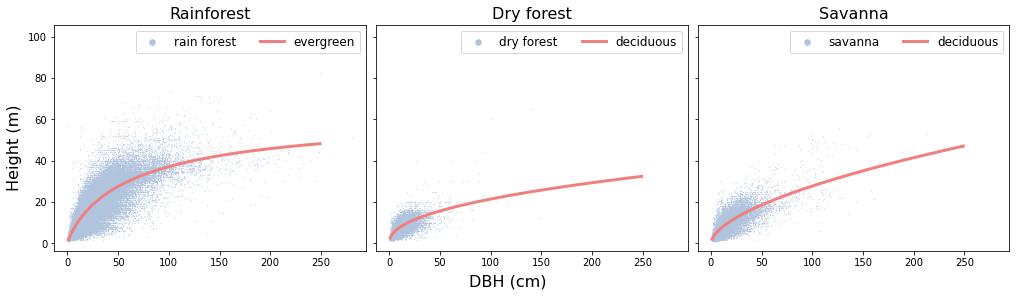

In [66]:
fig1, axs = plt.subplots(nrows=1, ncols=3, figsize=(14,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(rf['dbh'], rf['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].set_title('Rainforest',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)

axs[1].scatter(df['dbh'], df['height'], s=0.05, color='lightsteelblue', label = 'dry forest')
axs[1].plot(ds, curve_df, color='lightcoral',label='deciduous',linewidth=3.0)
axs[1].set_title('Dry forest',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)

axs[2].scatter(s['dbh'], s['height'], s=0.05, color='lightsteelblue', label = 'savanna')
axs[2].plot(ds, curve_s, color='lightcoral',label='deciduous',linewidth=3.0)
axs[2].set_title('Savanna',  fontsize=16)
axs[2].legend(fontsize=12, ncol=2, markerscale=25)

fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)



### Combining dry forests and savannas 

Text(0.02, 0.5, 'Height (m)')

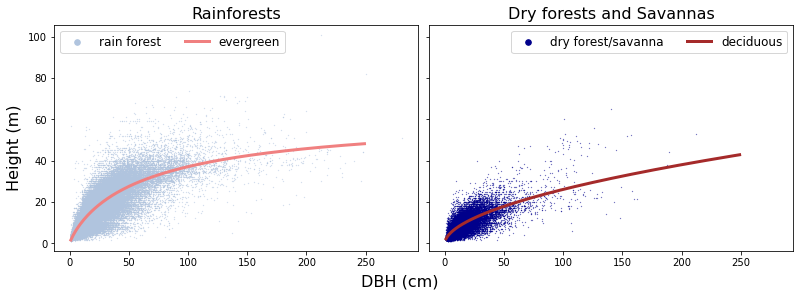

In [67]:
fig1, axs = plt.subplots(nrows=1, ncols=2, figsize=(11,4), constrained_layout=True, sharex=True, sharey=True)
axs=axs.flatten()

axs[0].scatter(rf['dbh'], rf['height'], s=0.05, color='lightsteelblue', label = 'rain forest')
axs[0].plot(ds, curve_rf, color='lightcoral',label='evergreen',linewidth=3.0)
axs[0].set_title('Rainforests',  fontsize=16)
axs[0].legend(fontsize=12, ncol=2, markerscale=25)

axs[1].scatter(dfs['dbh'], dfs['height'], s=0.05, color='lightsteelblue', label = 'dry forest/savanna')
axs[1].plot(ds, curve_dfs, color='lightcoral',label='deciduous',linewidth=3.0)
axs[1].set_title('Dry forests and Savannas',  fontsize=16)
axs[1].legend(fontsize=12, ncol=2, markerscale=25)


fig1.supxlabel('DBH (cm)', fontsize=16)
fig1.supylabel('Height (m)', fontsize=16)